In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
%%time
imdb_data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)
CPU times: user 690 ms, sys: 195 ms, total: 885 ms
Wall time: 2.07 s


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
#split the dataset
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [6]:
import nltk
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

/tmp/ipykernel_33/841911545.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [8]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [9]:
import nltk
from nltk.stem import PorterStemmer

# Initializing the Porter Stemmer
ps = PorterStemmer()

# Define the stemming function
def simple_stemmer(text):
    # Split text into words, stem each word, and join them back into a string
    stemmed_text = ' '.join([ps.stem(word) for word in text.split()])
    return stemmed_text

# Apply the stemming function to the 'review' column
imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)

In [10]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'yourselves', 'against', 'to', 'as', 't', 'with', 'up', 'myself', 'same', 'isn', 'you', 'having', 'just', "couldn't", "hadn't", 'couldn', 'should', 'then', 'each', "haven't", "she's", 'yours', 'yourself', 'he', 'no', 'through', 'those', 've', 'at', 'is', 'down', 'have', 'if', 'so', 'be', 'when', "mightn't", 'before', 'for', 'them', 'don', "isn't", 'below', 'are', 'too', 'do', "you've", 'both', "shan't", "that'll", 'into', 'we', 'him', 'over', 'me', 'by', 'during', 'who', 'your', 'until', 'hers', 'an', 'out', 'had', 'doing', 'very', "aren't", 'own', 'more', 'doesn', 'won', 'aren', 'shan', 'wasn', 'she', 'm', "wouldn't", 'ourselves', 'll', 'and', "shouldn't", 'few', 'will', 'weren', 'any', 'while', 'this', 'does', "doesn't", 'above', 'such', 'her', 'shouldn', 'they', 'most', 'all', "you're", 'or', "it's", 'off', 'nor', 'himself', 'than', 'been', "you'll", 'wouldn', 'what', 'about', 'which', 'only', 'why', 'whom', 'our', 'once', 'on', 'there', 's', 'ma', 'its', 'my', 'now', 'from', 'need

In [11]:
imdb_data.sentiment.replace("positive" , 1 , inplace = True)
imdb_data.sentiment.replace("negative" , 0 , inplace = True)
imdb_data.head()

/tmp/ipykernel_33/193489270.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imdb_data.sentiment.replace("positive" , 1 , inplace = True)
/tmp/ipykernel_33/193489270.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,review,sentiment
0,one review ha mention watch 1 Oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imdb_data['review'], imdb_data['sentiment'], test_size=0.20, random_state=0)

In [13]:
cv = CountVectorizer(max_features=2500)
# Fit and transform on the training data
X_train_cv = cv.fit_transform(X_train).toarray()
# Transform the test data
X_test_cv = cv.transform(X_test).toarray()

In [14]:
models = dict()
models['Logistic Regression'] = LogisticRegression(max_iter=1000)
models['XGB']= XGBClassifier(n_estimators=5000)
models['Support Vector Machine'] = SVC(kernel = 'sigmoid', gamma='scale')
models['Decision Tree'] = DecisionTreeClassifier(max_depth=100)
models['Random Forest'] = RandomForestClassifier()
models['kNN'] = KNeighborsClassifier()
models['SGD']=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None)
models['MNB']=MultinomialNB()
for model in models:
    models[model].fit(X_train_cv, y_train)
    print(model + " model fitting completed.")

Logistic Regression model fitting completed.
XGB model fitting completed.
Support Vector Machine model fitting completed.
Decision Tree model fitting completed.
Random Forest model fitting completed.
kNN model fitting completed.
SGD model fitting completed.
MNB model fitting completed.


Test Set Prediction:

--------------------Logistic Regression--------------------
              precision    recall  f1-score   support

           0    0.87368   0.86812   0.87089      5035
           1    0.86712   0.87271   0.86991      4965

    accuracy                        0.87040     10000
   macro avg    0.87040   0.87042   0.87040     10000
weighted avg    0.87042   0.87040   0.87040     10000



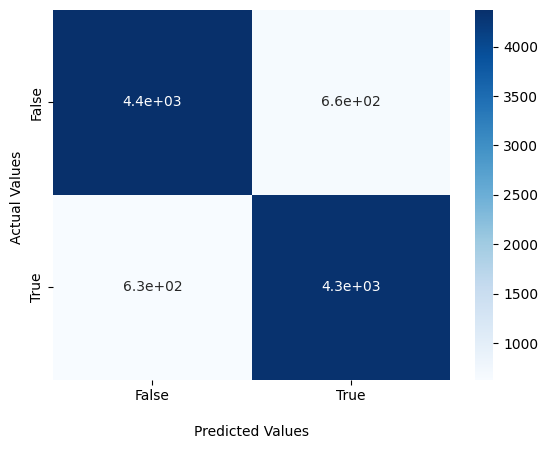

--------------------XGB--------------------
              precision    recall  f1-score   support

           0    0.87749   0.87627   0.87688      5035
           1    0.87470   0.87593   0.87531      4965

    accuracy                        0.87610     10000
   macro avg    0.87609   0.87610   0.87610     10000
weighted avg    0.87610   0.87610   0.87610     10000



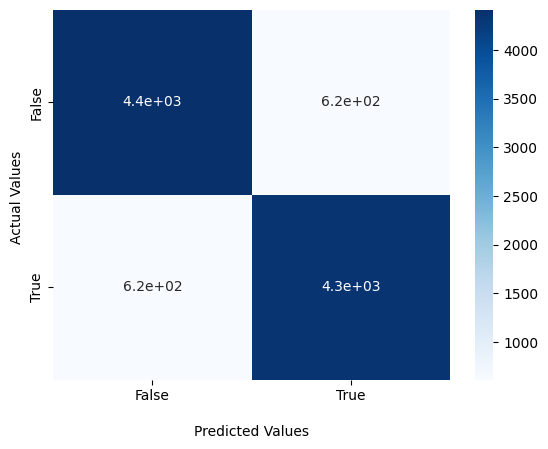

--------------------Support Vector Machine--------------------
              precision    recall  f1-score   support

           0    0.64214   0.65680   0.64939      5035
           1    0.64371   0.62880   0.63617      4965

    accuracy                        0.64290     10000
   macro avg    0.64292   0.64280   0.64278     10000
weighted avg    0.64292   0.64290   0.64282     10000



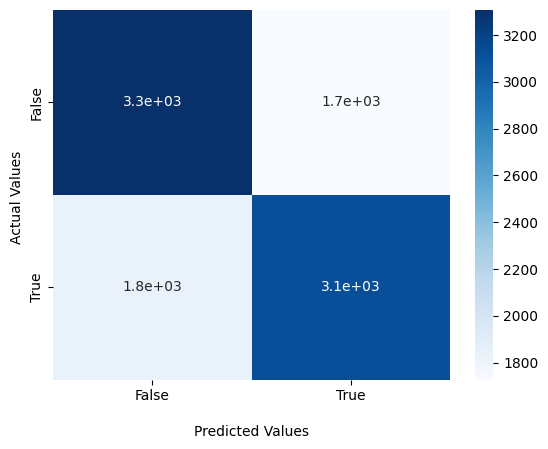

--------------------Decision Tree--------------------
              precision    recall  f1-score   support

           0    0.71998   0.72771   0.72382      5035
           1    0.72083   0.71299   0.71689      4965

    accuracy                        0.72040     10000
   macro avg    0.72041   0.72035   0.72036     10000
weighted avg    0.72040   0.72040   0.72038     10000



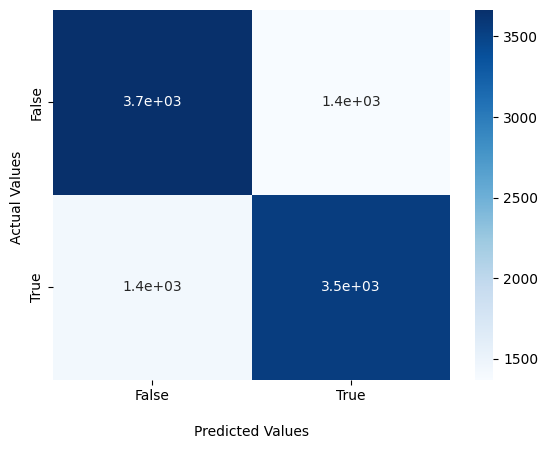

--------------------Random Forest--------------------
              precision    recall  f1-score   support

           0    0.83954   0.84687   0.84319      5035
           1    0.84332   0.83585   0.83957      4965

    accuracy                        0.84140     10000
   macro avg    0.84143   0.84136   0.84138     10000
weighted avg    0.84142   0.84140   0.84139     10000



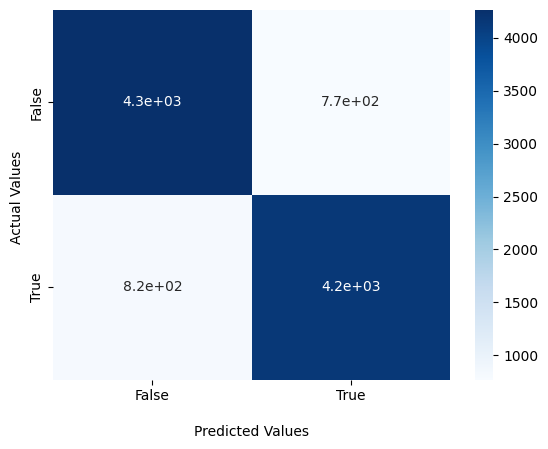

--------------------kNN--------------------
              precision    recall  f1-score   support

           0    0.66113   0.65561   0.65836      5035
           1    0.65368   0.65921   0.65644      4965

    accuracy                        0.65740     10000
   macro avg    0.65741   0.65741   0.65740     10000
weighted avg    0.65743   0.65740   0.65740     10000



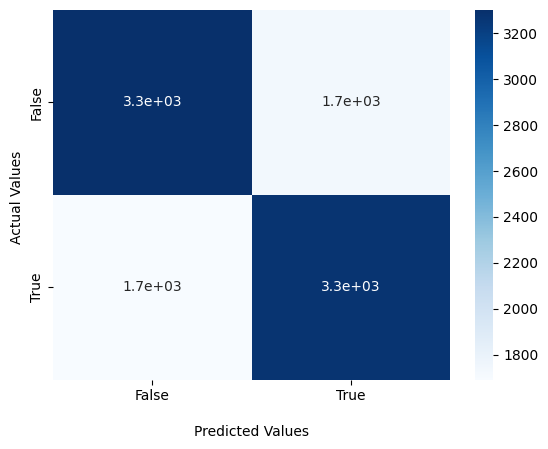

--------------------SGD--------------------
              precision    recall  f1-score   support

           0    0.89435   0.84906   0.87112      5035
           1    0.85441   0.89829   0.87580      4965

    accuracy                        0.87350     10000
   macro avg    0.87438   0.87367   0.87346     10000
weighted avg    0.87452   0.87350   0.87344     10000



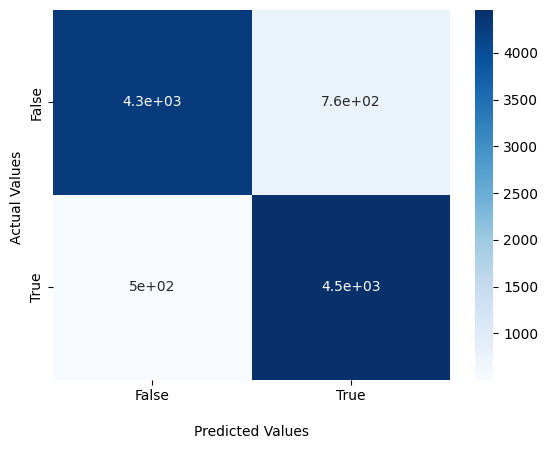

--------------------MNB--------------------
              precision    recall  f1-score   support

           0    0.82698   0.84012   0.83350      5035
           1    0.83521   0.82175   0.82843      4965

    accuracy                        0.83100     10000
   macro avg    0.83109   0.83094   0.83096     10000
weighted avg    0.83107   0.83100   0.83098     10000



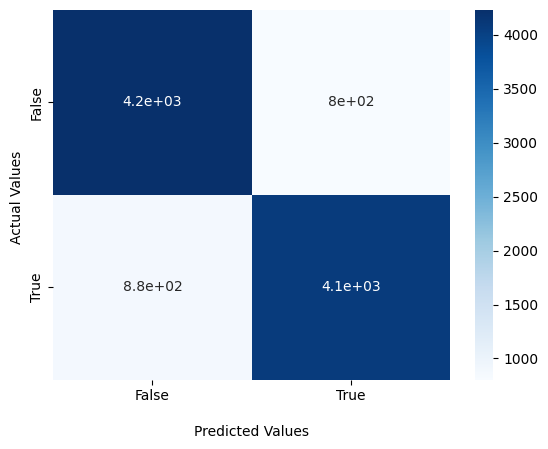

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_test is a list of text samples
# Convert the text samples into BoW vectors using the same CountVectorizer
X_test_cv = cv.transform(X_test).toarray()

print("Test Set Prediction:\n")
for x in models:
    print('-'*20+x+'-'*20)
    try:
        # Make predictions
        y_pred = models[x].predict(X_test_cv)
        
        # Print classification report
        print(classification_report(y_test, y_pred, digits=5))
        
        # Plot confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])
        plt.show()
    except Exception as e:
        print("An error occurred during prediction:", e)


In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform on the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the test labels
y_test_encoded = label_encoder.transform(y_test)
